# Purity and excitation probability comparison

We will use a square wavepacket and compare markovian and wavepacket evolution.

Note:

3dB of squeezing is $r \approx 0.31$


4.5dB of squeezing is $r \approx 0.51$



In [39]:
plt.style.use('../../../../jupyter/research-notebooks/website.mplstyle')

In [1]:
from functools import partial
import pickle
import numpy as np
from scipy.integrate import quad

from tqdm import tqdm_notebook

import pysme.hierarchy as hier
import pysme.integrate as integ

import matplotlib.pyplot as plt
import matplotlib
# #from quantum_utilities.qubits import Id, sigm, sigz, zero

In [2]:
# Define Lowering operator and Sigma Z

Id = np.eye(2, dtype=complex)

zero = np.zeros((2,2), dtype=complex)

sigz = np.array([[1, 0], [0, -1]], dtype=complex)

sigx = np.array([[0, 1], [1, 0]], dtype=complex)

sigy = np.array([[0, -1j], [1j, 0]], dtype=complex)

sigm = np.array([[0, 0], [1, 0]], dtype=complex)

In [3]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

# Match inital decay

In [85]:
# rs = np.arcsinh(np.sqrt(np.arange(5)))
# print('rs', rs)
# print('exp(rs)', np.exp(rs))
# print('sinh(rs)^2', np.sinh(rs)**2)


n_max = 22

Omega = 0 #1.21

# 3dB of squeezing  r \approx =0.31
3 / (20* np.log10(np.e))

# 4.5dB of squeezing r \approx 0.51
r = 4.5/ (20* np.log10(np.e))



r_val_wp = r 

#r_val_bb = 0.2335848289126526

mu_val = 0

gam = 1

xi_len = 4

S = Id
L = np.sqrt(gam) * sigm
H = zero

rho0 = (Id + (sigx + sigy)/np.sqrt(2))/2 # np.array([[1, 0], [0, 0]], dtype=complex) # excited state

xi = xi_rect


times = np.linspace(0, xi_len + 2, num=xi_len*30 + 60)

### Wavepacket

In [86]:
factory = hier.HierarchyIntegratorFactory(2, n_max)
           
integrators = factory.make_uncond_integrator(partial(xi, a=0, b=xi_len), S, L, H, r=r_val_wp, mu=mu_val)

In [87]:
solns = integrators.integrate(rho0, times)

In [88]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

### Vacuum evolution

In [89]:
vac_integrator_object = integ.UncondLindbladIntegrator([L],H)
vac_soln = vac_integrator_object.integrate(rho0, times)

### Markovian Squeezed evolution

here we numerically optimize over the squeeze parameter to match the inital decay of the wavepacket solution

In [90]:
# Wavepacket shape
# TODO: make wavepacket return to vac soln after x>b: f1-> 1 & f2 -> 0
def f1(x, a, b, mu, r):
    return np.cosh(r)*np.where(x < a, 0, np.where(x < b, 1, 0))

def f2(x, a, b, mu, r):
    return np.exp(2j*mu)* np.sinh(r)*np.where(x < a, 0, np.where(x < b, 1, 0))


#fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
#fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

#L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
#H_list = [H]

#broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
#markov_soln = broadband_integrator_object.integrate(rho0, times)

find squeezing amount to match the decay curve over the first 1 unit of time of the wavepacket

In [91]:
stz = 0.0
stp = 1.01
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = solns.get_expectations(sigx, vac_rho(n_max))
y_wp = solns.get_expectations(sigy, vac_rho(n_max))
z_wp = (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2
xwp = x_wp[startz:endz]
ywp = y_wp[startz:endz]
zwp = z_wp[startz:endz]


def func(r_val_bb, *params):
    times, L, H, xi_len, mu_val, rho0 , xwp, ywp, zwp, startz, endz = params
    fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
    H_list = [H]
    broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
    markov_soln = broadband_integrator_object.integrate(rho0, times)
    x_m = markov_soln.get_expectations(sigx)
    y_m = markov_soln.get_expectations(sigy)
    z_m = (markov_soln.get_expectations(sigz) + 1)/2
    xm = x_m[startz:endz]
    ym = y_m[startz:endz]
    zm = z_m[startz:endz]
    return np.sum( (ywp - ym)**2) + np.sum( (xwp - xm)**2)

the index of t=0.0 is  0
the index of t=1.01 is  30


In [92]:
from scipy import optimize
paramz = (times, L, H, xi_len, mu_val, rho0, xwp, ywp, zwp, startz, endz)
rangez = (0.0051,0.43)

soln = optimize.minimize_scalar(func, bracket=None, bounds=rangez, args=paramz)

print(soln)

r_val_bb = soln.x

     fun: 0.009175521394508623
    nfev: 14
     nit: 10
 success: True
       x: 0.09570808436182314


simulate markovian squeezed evolution with  numercially found optimal amount of squeezing

In [94]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
H_list = [H]
broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)
x_m = markov_soln.get_expectations(sigx)
y_m = markov_soln.get_expectations(sigy)
z_m = (markov_soln.get_expectations(sigz) + 1)/2
xm = x_m[startz:endz]
ym = y_m[startz:endz]
zm = z_m[startz:endz]

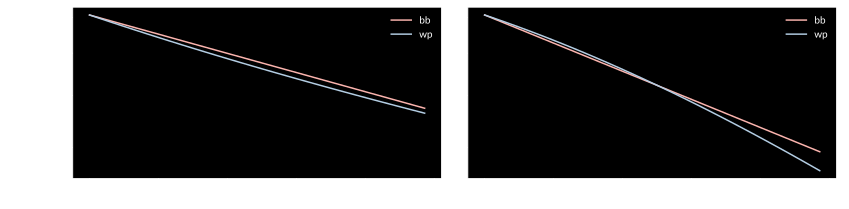

In [95]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
axs[0].semilogy(times[startz:endz], xm, label='bb')
axs[0].semilogy(times[startz:endz], xwp, label='wp')
axs[0].legend()
axs[1].semilogy(times[startz:endz], ym, label='bb')
axs[1].semilogy(times[startz:endz], ywp, label='wp')
axs[1].legend()
plt.tight_layout()

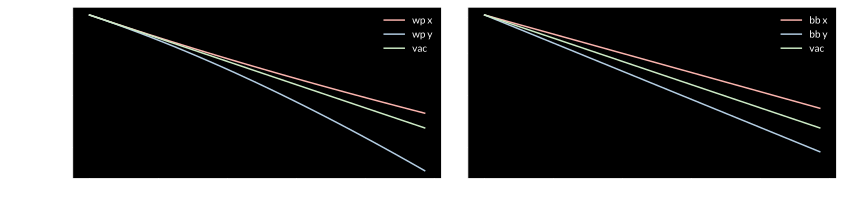

In [100]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
axs[0].semilogy(times[startz:endz], xwp, label='wp x')
axs[0].semilogy(times[startz:endz], ywp, label='wp y')
axs[0].semilogy(times[startz:endz], vac_soln.get_expectations(sigx)[startz:endz], label='vac')
axs[0].legend()
axs[1].semilogy(times[startz:endz], xm, label='bb x')
axs[1].semilogy(times[startz:endz], ym, label='bb y')
axs[1].semilogy(times[startz:endz], vac_soln.get_expectations(sigx)[startz:endz], label='vac')
axs[1].legend()
plt.tight_layout()

In [63]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]

H_list = [H]

broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)

In [64]:
#M and N params
M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
N = np.sinh(r_val_bb)**2

print(N,M)

0.00918804035568729 (-0.09629361578663992-0j)


In [65]:
# expected modification of decay rate relative to vac
2*N+1


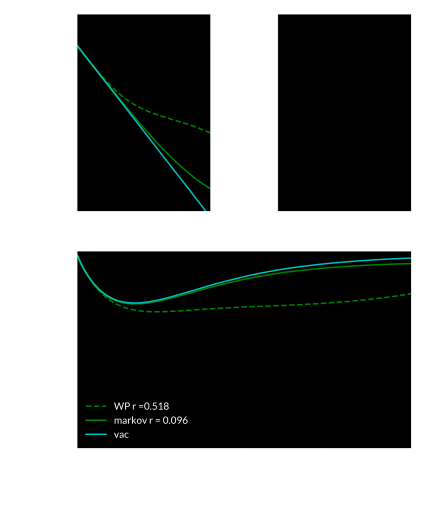

In [70]:
gs = matplotlib.gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=[6, 8])

gs = fig.add_gridspec(ncols=2, nrows=2,wspace=0.5)


f3_ax0 = fig.add_subplot(gs[0, :-1])
f3_ax1 = fig.add_subplot(gs[0, 1])
f3_ax2 = fig.add_subplot(gs[1, :])


rwp_plot = np.round(r_val_wp,3)
rbb_plot = np.round(r_val_bb,3)

f3_ax0.plot(times, xi_rect(times,a=0, b=xi_len),label='WP',linestyle='--',color='k')
f3_ax0.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
f3_ax0.plot(times, (markov_soln.get_expectations(sigz) + 1)/2, label='Z markov',linestyle='-',color='g')
f3_ax0.plot(times, (vac_soln.get_expectations(sigz) + 1)/2, label='Z vac',linestyle='-',color='c')
f3_ax0.set_yscale('log')
f3_ax0.set_xlim(0.0, 4.025)
f3_ax0.set_ylim(1e-2, 1.05) 
f3_ax0.set_ylabel(r'$\langle Z \rangle $',rotation=0,labelpad=10) 
f3_ax0.set_xlabel(r'$\gamma\, t $')



f3_ax1.plot(times, xi_rect(times,a=0, b=xi_len),label='WP',linestyle='--',color='k')
f3_ax1.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
f3_ax1.plot(times, (markov_soln.get_expectations(sigz) + 1)/2, label='Z markov',linestyle='-',color='g')
f3_ax1.plot(times, (vac_soln.get_expectations(sigz) + 1)/2, label='Z vac',linestyle='-',color='c')
f3_ax1.set_yscale('log')
f3_ax1.set_xlim(0.2, 0.4)
f3_ax1.set_ylim(6.75e-1, 8e-1) 
f3_ax1.set_xlabel(r'$\gamma\, t $')



f3_ax2.plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='--',color='g')
f3_ax2.plot(times, markov_soln.get_purities(),label='markov r = ' + str(rbb_plot), linestyle='-',color='g')
f3_ax2.plot(times, vac_soln.get_purities(),label='vac',linestyle='-',color='c')
#f3_ax2.set_yscale('log')
f3_ax2.set_xlim(0.0, 4.025)
f3_ax2.set_ylim(0.497, 1.01) 
f3_ax2.set_xlabel(r'$\gamma\, t $')
f3_ax2.set_ylabel(r'Purity',labelpad=5)
f3_ax2.legend()

# Match steady state exitation probablity

In [77]:
# rs = np.arcsinh(np.sqrt(np.arange(5)))
# print('rs', rs)
# print('exp(rs)', np.exp(rs))
# print('sinh(rs)^2', np.sinh(rs)**2)


n_max = 22

Omega = 0 #1.21

# 3dB of squeezing  r \approx =0.31
3 / (20* np.log10(np.e))

# 4.5dB of squeezing r \approx 0.51
r = 4.5/ (20* np.log10(np.e))



r_val_wp = r 

r_val_bb = 0.2335848289126526

mu_val = 0

gam = 1

xi_len = 9


S = Id
L = np.sqrt(gam) * sigm
H = zero


rho0 = np.array([[1, 0], [0, 0]], dtype=complex) # excited state
#

xi = xi_rect



times = np.linspace(0, xi_len + 2, num=xi_len*30 + 60)



In [78]:
# wavepacket 

factory = hier.HierarchyIntegratorFactory(2, n_max)
           
integrators = factory.make_uncond_integrator(partial(xi, a=0, b=xi_len), S, L, H, r=r_val_wp, mu=mu_val)

solns = integrators.integrate(rho0, times)

In [80]:
# vaccum
vac_integrator_object = integ.UncondLindbladIntegrator([L],H)
vac_soln = vac_integrator_object.integrate(rho0, times)

In [81]:
stz = 5.0
stp = 9.0
print('the index of t='+str(stz)+' is ', np.argmin((times-stz)**2))
print('the index of t='+str(stp)+' is ', np.argmin((times-stp)**2))

startz = np.argmin((times-stz)**2)
endz = np.argmin((times-stp)**2)
tp = times[startz:endz]
x_wp = (solns.get_expectations(sigx, vac_rho(n_max)) + 1)/2
z_wp = (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2
xwp = x_wp[startz:endz]
zwp = z_wp[startz:endz]


def func(r_val_bb, *params):
    times, L, H, xi_len, mu_val, rho0 , xwp, zwp, startz, endz = params
    fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
    L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]
    H_list = [H]
    broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
    markov_soln = broadband_integrator_object.integrate(rho0, times)
    x_m = (markov_soln.get_expectations(sigx) + 1)/2
    z_m = (markov_soln.get_expectations(sigz) + 1)/2
    xm = x_m[startz:endz]
    zm = z_m[startz:endz]
    return np.sum( (zwp-zm)**2)

the index of t=5.0 is  150
the index of t=9.0 is  269


In [82]:
from scipy import optimize
paramz = (times, L, H, xi_len, mu_val, rho0 , xwp, zwp, startz, endz)
rangez = (0.0051,0.43)


soln = optimize.minimize_scalar(func, bracket=None, bounds=rangez, args=paramz)

print(soln)

r_val_bb = soln.x

     fun: 0.0021633866552086666
    nfev: 18
     nit: 14
 success: True
       x: 0.22490165189242894


In [83]:
fc = partial(f1, a=0, b=xi_len, mu=mu_val, r=r_val_bb)
fs = partial(f2, a=0, b=xi_len, mu=mu_val, r=r_val_bb)

L_list = [[(L, fc), (np.conj(np.transpose(L)), fs)]]

H_list = [H]

broadband_integrator_object = integ.UncondTimeDepLindInt(L_list, H_list)
markov_soln = broadband_integrator_object.integrate(rho0, times)

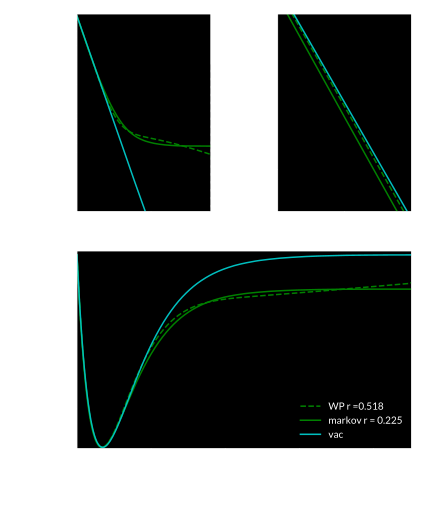

In [84]:
gs = matplotlib.gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=[6, 8])

gs = fig.add_gridspec(ncols=2, nrows=2,wspace=0.5)


f3_ax0 = fig.add_subplot(gs[0, :-1])
f3_ax1 = fig.add_subplot(gs[0, 1])
f3_ax2 = fig.add_subplot(gs[1, :])


rwp_plot = np.round(r_val_wp,3)
rbb_plot = np.round(r_val_bb,3)

f3_ax0.plot(times, xi_rect(times,a=0, b=xi_len),label='WP',linestyle='--',color='k')
f3_ax0.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
f3_ax0.plot(times, (markov_soln.get_expectations(sigz) + 1)/2, label='Z markov',linestyle='-',color='g')
f3_ax0.plot(times, (vac_soln.get_expectations(sigz) + 1)/2, label='Z vac',linestyle='-',color='c')
f3_ax0.set_yscale('log')
f3_ax0.set_xlim(0.0, 9.025)
f3_ax0.set_ylim(1e-2, 1.05) 
f3_ax0.set_ylabel(r'$\langle Z \rangle $',rotation=0,labelpad=10) 
f3_ax0.set_xlabel(r'$\gamma\, t $')



f3_ax1.plot(times, xi_rect(times,a=0, b=xi_len),label='WP',linestyle='--',color='k')
f3_ax1.plot(times, (solns.get_expectations(sigz, vac_rho(n_max)) + 1)/2,label='Z wp',linestyle='--',color='g')
f3_ax1.plot(times, (markov_soln.get_expectations(sigz) + 1)/2, label='Z markov',linestyle='-',color='g')
f3_ax1.plot(times, (vac_soln.get_expectations(sigz) + 1)/2, label='Z vac',linestyle='-',color='c')
f3_ax1.set_yscale('log')
f3_ax1.set_xlim(0.2, 0.4)
f3_ax1.set_ylim(6.75e-1, 8e-1) 
f3_ax1.set_xlabel(r'$\gamma\, t $')



f3_ax2.plot(times, solns.get_purities(vac_rho(n_max)),label='WP r =' + str(rwp_plot),linestyle='--',color='g')
f3_ax2.plot(times, markov_soln.get_purities(),label='markov r = ' + str(rbb_plot), linestyle='-',color='g')
f3_ax2.plot(times, vac_soln.get_purities(),label='vac',linestyle='-',color='c')
#f3_ax2.set_yscale('log')
f3_ax2.set_xlim(0.0, 9.025)
f3_ax2.set_ylim(0.497, 1.01) 
f3_ax2.set_xlabel(r'$\gamma\, t $')
f3_ax2.set_ylabel(r'Purity',labelpad=5)
f3_ax2.legend()


In [22]:
## M and N params
##M = - np.exp(2j*mu_val)* np.sinh(r_val_bb) * np.cosh(r_val_bb)
##N = np.sinh(r_val_bb)**2

